In [1]:
# 06 – Example: Methane offset potential of an evolving C-sink (annual stock-change method)

# This notebook implements Eq. (15) and Eq. (19) to compute:

# - the total climate effect delivered by an evolving CO₂ sink over horizon **H**
# - the methane mass **M_CH4(H)** that can be offset by that sink

### Inputs
# - An Excel file with an end-of-year certified sink stock time series **M_sink(t)** in tCO₂e.
# - Offset horizon **H** (years).
# - Methane **GWP100** (tCO₂e / tCH₄).

### Outputs
# - **TCE_sink(H)** in tCO₂e·yr
# - **M_CH4(H)** in tCH₄
# - Two plots:
#  1) sink stock series M_sink(t)
#  2) methane offset potential M_CH4(H) accumulating over the horizon

## User settings

# Place your Excel file in the same folder as this notebook.

# Convention in this repository:
# - CO₂ removals (sink accumulation) are **negative**
# - CO₂ releases are **positive**

# If your Excel uses the opposite convention, multiply the sink stock series by −1.

## Load sink stock time series from Excel

# The Excel file must contain:
# - a `year` column (0, 1, 2, …)
# - one sink-stock column containing the end-of-year certified stock in tCO₂e
#  (e.g. `Msink`, `Msink in t CO2e`, etc.)

# The code detects the sink-stock column automatically if it contains the substring `Msink`.



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# USER SETTINGS
# -----------------------------

excel_path = "evolving_sink_data_01.xlsx"  # Excel file in same folder as notebook
H = 20                                    # offset horizon (years)
GWP100_CH4 = 27.0                         # tCO2e / tCH4

# data input from excel sheet

df = pd.read_excel(excel_path).sort_values("year").reset_index(drop=True)

# Detect the sink-stock column (anything that contains 'msink' case-insensitive)
stock_cols = [c for c in df.columns if "msink" in c.lower()]

if len(stock_cols) == 0:
    raise ValueError("No sink stock column found. Please include a column named like 'Msink' or 'Msink in t CO2e'.")
if len(stock_cols) > 1:
    raise ValueError(f"Multiple sink stock columns found: {stock_cols}. Please keep only one stock column.")

df = df.rename(columns={stock_cols[0]: "Msink"})

print("Detected sink-stock column:", stock_cols[0])
df.head()


Detected sink-stock column: Msink in t CO2e


,year,Msink
0,0,-10.0
1,1,-70.0
2,2,-90.0
3,3,-140.0
4,4,200.0


In [3]:
# IRF coding
## IRF and integrated IRF
# We use the Jeltsch–Thömmes & Joos (2019) IRF formulation.
# Integrated IRF used in Eq. (15) and Eq. (19):
# IRF_int(x) = ∫0^x IRF(u) du = a0·x + Σ a_i·τ_i·(1 – exp(−x/τ_i))

# -----------------------------
# IRF parameters (Jeltsch–Thömmes & Joos, 2019)
# -----------------------------

a0 = 0.008
a  = np.array([0.044, 0.112, 0.224, 0.310, 0.297], dtype=float)
tau = np.array([68521.0, 5312.0, 362.0, 47.0, 6.0], dtype=float)

def IRF_int(x):
    """Analytic integral ∫0^x IRF(u) du"""
    x = np.asarray(x, dtype=float)
    return a0*x + np.sum(a*tau*(1.0 - np.exp(-x/tau)), axis=0)

IRF100 = IRF_int(100.0)
print(f"IRF_int(100) = {IRF100:.6f} yr")

## Midpoint stock series and annual impulses
# From end-of-year certified stocks M_sink(t), we compute:
# Eq. (14b): midpoint stock
# M_mid(t) = (M_sink(t−1) + M_sink(t)) / 2
# Eq. (14c): annual impulse credited at mid-year
# M_impulse(t) = M_mid(t) − M_mid(t−1)

# Restrict to years 0..H
d = df[df["year"].between(0, H)].copy().set_index("year")
Ms = d["Msink"]

# Midpoint stocks (Eq. 14b)
M_mid = {0: Ms.loc[0]}
for t in range(1, H+1):
    M_mid[t] = 0.5 * (Ms.loc[t-1] + Ms.loc[t])
M_mid = pd.Series(M_mid, name="M_mid")

# Impulses (Eq. 14c)
M_impulse = {t: M_mid.loc[t] - M_mid.loc[t-1] for t in range(1, H+1)}
M_impulse = pd.Series(M_impulse, name="M_impulse")

pd.DataFrame({"M_sink_end": Ms, "M_mid": M_mid}).head(10)

## Compute TCE_sink(H) and methane offset potential M_CH4(H)
# Eq. (15):
# TCE_sink(H) = − Σ_{t=1..H} M_impulse(t) · IRF_int(H − t + 1/2)
# Eq. (19):
# M_CH4(H) = [ − Σ_{t=1..H} M_impulse(t) · IRF_int(H − t + 1/2) ] / [ GWP100(CH4) · IRF_int(100) ]

# Remaining-time weights for each pulse year t
weights = np.array([IRF_int(H - t + 0.5) for t in range(1, H+1)])

# Kernel sum S(H)
S = float(np.sum(M_impulse.values * weights))

# Total climate effect of sink (tCO2e·yr)
TCE_sink = -S

# Offsettable methane mass (tCH4)
M_CH4 = (-S) / (GWP100_CH4 * IRF100)

print(f"H = {H} years")
print(f"TCE_sink({H}) = {TCE_sink:.6f} tCO2e·yr")
print(f"M_CH4_offsettable({H}) = {M_CH4:.6f} tCH4   (GWP100 = {GWP100_CH4})")


## Methane offset potential accumulating over the horizon
# We compute M_CH4(h) for all horizons h = 1…H to show how methane offset potential evolves over time.
M_CH4_by_h = {}
TCE_by_h = {}

for h in range(1, H+1):
    Ms_h = Ms.loc[0:h]

    # recompute midpoint stock up to h
    M_mid_h = {0: Ms_h.loc[0]}
    for t in range(1, h+1):
        M_mid_h[t] = 0.5*(Ms_h.loc[t-1] + Ms_h.loc[t])
    M_mid_h = pd.Series(M_mid_h)

    # recompute impulse up to h
    M_imp_h = {t: M_mid_h.loc[t] - M_mid_h.loc[t-1] for t in range(1, h+1)}
    M_imp_h = pd.Series(M_imp_h)

    # compute weights and sum
    w = np.array([IRF_int(h - t + 0.5) for t in range(1, h+1)])
    S_h = float(np.sum(M_imp_h.values * w))

    TCE_by_h[h] = -S_h
    M_CH4_by_h[h] = (-S_h)/(GWP100_CH4 * IRF100)
M_CH4_by_h = pd.Series(M_CH4_by_h, name="M_CH4_offsettable")
pd.DataFrame({"M_CH4_offsettable": M_CH4_by_h})


IRF_int(100) = 50.480844 yr
H = 20 years
TCE_sink(20) = 3910.443183 tCO2e·yr
M_CH4_offsettable(20) = 2.869033 tCH4   (GWP100 = 27.0)


,M_CH4_offsettable
1,0.010798
2,0.045941
3,0.105940
4,0.123143
5,0.018986
6,-0.129667
7,-0.208349
8,-0.202189
9,-0.086748
10,0.151353


Final M_CH4(H): 2.8690334289756714
Min annual increment: -0.1486527886216006
Years where offset potential decreases:
5    -0.104157
6    -0.148653
7    -0.078682
14   -0.060360
Name: M_CH4_offsettable, dtype: float64


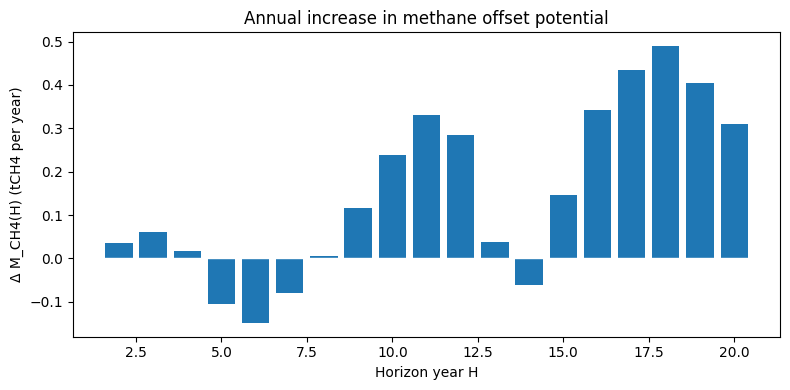

In [4]:
# some sanity checks:

M_series = pd.Series(M_CH4_by_h)

print("Final M_CH4(H):", M_series.iloc[-1])
print("Min annual increment:", M_series.diff().min())
print("Years where offset potential decreases:")
print(M_series.diff()[M_series.diff() < 0])

plt.figure(figsize=(8,4))
plt.bar(M_series.index, M_series.diff(), width=0.8)
plt.axhline(0, color="white", linewidth=1)
plt.xlabel("Horizon year H")
plt.ylabel("Δ M_CH4(H) (tCH4 per year)")
plt.title("Annual increase in methane offset potential")
plt.tight_layout()
plt.show()



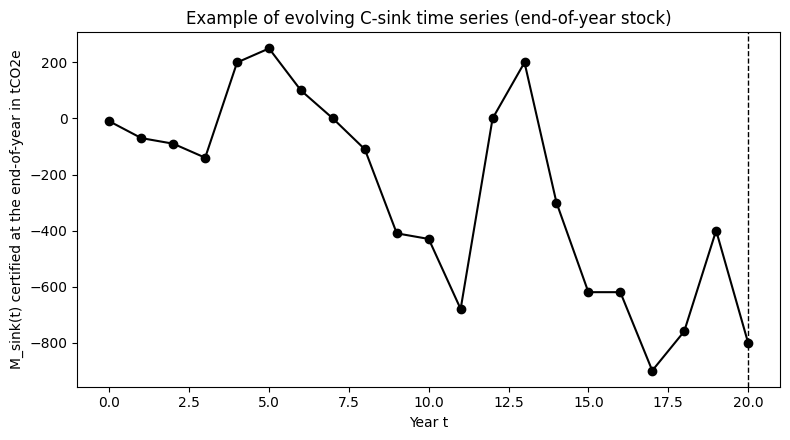

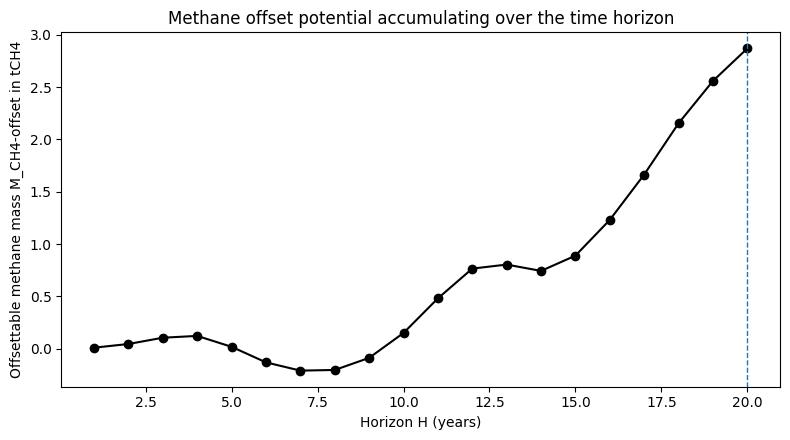

In [5]:
# drawing the mass C-sink (fig 1) and the CH4-offsetting (fig 2) graphs and saving them as jpg in the same folder as the program runs.

plt.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "axes.edgecolor": "black",
    "axes.labelcolor": "black",
    "xtick.color": "black",
    "ytick.color": "black",
    "text.color": "black",
    "grid.color": "0.8",
    "legend.facecolor": "white",
    "legend.edgecolor": "black",
})
# Figure 1: C-sink series
fig1 = plt.figure(figsize=(8, 4.5))
plt.plot(df[df["year"].between(0, H)]["year"],
         df[df["year"].between(0, H)]["Msink"],
         marker="o",  color="black")
plt.axvline(H, linestyle="--", color="black", linewidth=1)
plt.xlabel("Year t")
plt.ylabel("M_sink(t) certified at the end-of-year in tCO2e")
plt.title("Example of evolving C-sink time series (end-of-year stock)")
plt.tight_layout()
fig1.savefig("../figures/figure_C-sink.jpg", dpi=300, bbox_inches="tight", facecolor="white")
plt.show()

# Figure 2: CH4-offsetting
fig2 = plt.figure(figsize=(8, 4.5))
plt.plot(M_CH4_by_h.index, M_CH4_by_h.values, marker="o", color="black")
plt.axvline(H, linestyle="--", linewidth=1)
plt.xlabel("Horizon H (years)")
plt.ylabel("Offsettable methane mass M_CH4-offset in tCH4")
plt.title("Methane offset potential accumulating over the time horizon")
plt.tight_layout()
fig2.savefig("../figures/figure_evolving_CH4_offset.jpg", dpi=300, bbox_inches="tight", facecolor="white")
plt.show()
